# TMDB Movie Analysis

# Importing necessary libraries

In [33]:
import pandas as pd
import numpy as np
import ast
import json
import string
import re
import nltk
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.formula.api import ols
from statsmodels.compat import lzip
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [42]:
# Setting up directory
import os
os.chdir(r'C:\Users\Asus\OneDrive\Desktop\Semester 2\Data Mining for business analytics\FINAL PROJECT')
df1 = pd.read_csv('tmdb_5000_credits.csv')
df2 = pd.read_csv('tmdb_5000_movies.csv')

# Data Cleaning

In [43]:
print(df1.shape)
print(df2.shape)

df1["cast"] = df1["cast"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df1["crew"] = df1["crew"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df1["cast_names"] = df1["cast"].apply(lambda x: [d["name"] for d in x])
df1["director"] = df1["crew"].apply(lambda x: [d["name"] for d in x if d["job"] == "Director"][0] if [d["job"] for d in x if d["job"] == "Director"] else None)
df1["producer"] = df1["crew"].apply(lambda x: [d["name"] for d in x if d["job"] == "Producer"])
df1["screenplay_writer"] = df1["crew"].apply(lambda x: [d["name"] for d in x if d["job"] == "Screenplay"])

df1.dropna(subset=['director'], inplace=True)
for col in df1.columns:
    nan_count = df1[col].isna().sum()
    empty_count = df1[col].eq('').sum()
    print(f"Column {col}: NaN count = {nan_count}, Empty count = {empty_count}")

df1[['cast1', 'cast2', 'cast3']] = df1['cast_names'].apply(lambda x: (x[0], x[1], x[2]) if len(x)>=3 else [None, None, None]).apply(pd.Series)
df1.drop('cast_names', axis=1, inplace=True)


df2["release_date"] = pd.to_datetime(df2["release_date"])
df2['first_genre'] = ""

for i in range(len(df2)):
    if isinstance(df2.loc[i, 'genres'], str):
        match = re.findall('(?<=name\": \")[^\"]+', df2.loc[i, 'genres'])
        if len(match) > 0:
            df2.loc[i, 'first_genre'] = match[0]

df2['first_genre'] = pd.Categorical(df2['first_genre'])

df2["profit"] = df2["revenue"] - df2["budget"]
df2 = df2.reindex(columns = ['id', 'first_genre', 'title', 'vote_average', 'revenue', 'budget', 'profit', 'popularity', 'runtime', 'release_year'])
movies = df2.merge(df1, on="title")
movies = movies.drop("movie_id", axis=1)

(4803, 4)
(4805, 20)
Column movie_id: NaN count = 0, Empty count = 0
Column title: NaN count = 0, Empty count = 0
Column cast: NaN count = 0, Empty count = 0
Column crew: NaN count = 0, Empty count = 0
Column cast_names: NaN count = 0, Empty count = 0
Column director: NaN count = 0, Empty count = 0
Column producer: NaN count = 0, Empty count = 0
Column screenplay_writer: NaN count = 0, Empty count = 0


# Linear Regression

                            OLS Regression Results                            
Dep. Variable:           vote_average   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     196.7
Date:                Mon, 12 Feb 2024   Prob (F-statistic):           8.11e-44
Time:                        18:14:06   Log-Likelihood:                -7336.3
No. Observations:                4779   AIC:                         1.468e+04
Df Residuals:                    4777   BIC:                         1.469e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.9939      0.018    328.933      0.0

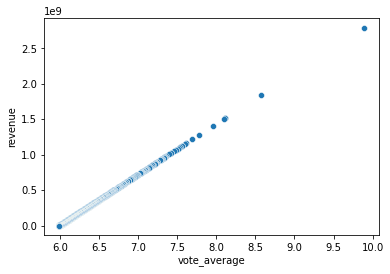

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.261e+32
Date:                Mon, 12 Feb 2024   Prob (F-statistic):               0.00
Time:                        18:14:06   Log-Likelihood:                 63931.
No. Observations:                4779   AIC:                        -1.279e+05
Df Residuals:                    4774   BIC:                        -1.278e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         8.279e+07   5.43e-09   1.53e+16   

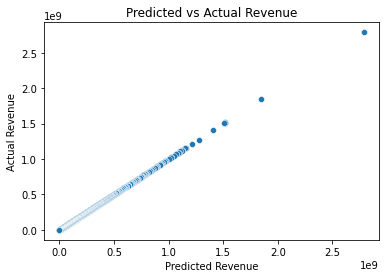

In [36]:
# Linear Regression with only one independent variable
x = movies['revenue']
y = movies['vote_average']

# Fit the model and print results
x = sm.add_constant(x)
model1 = sm.OLS(y, x).fit()
results_model1 = model1.summary()
print(results_model1)

movies["vote_average"] = model1.predict(x)
sns.scatterplot(data=movies, x="vote_average", y="revenue")
plt.show()

# Linear Regression with multiple independent variables
x = movies[['vote_average', 'budget', 'popularity', 'runtime']]
y = movies['revenue']


imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)
x_imputed = np.nan_to_num(x_imputed)
if np.any(np.isinf(x_imputed)):
    print("Warning: Infinite values still present after handling missing values")


scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_imputed)

x_scaled = sm.add_constant(x_scaled)

x_columns = ['const'] + ['vote_average', 'budget', 'popularity', 'runtime']
x_scaled_df = pd.DataFrame(x_scaled, columns=x_columns)

model2 = sm.OLS(y, x_scaled_df).fit()

print(model2.summary())

movies["revenue_predicted"] = model2.predict(x_scaled_df)
sns.scatterplot(data=movies, x="revenue_predicted", y="revenue")
plt.xlabel("Predicted Revenue")
plt.ylabel("Actual Revenue")
plt.title("Predicted vs Actual Revenue")
plt.show()

# Decision Tree Analysis

Train RMSE: 17623342.952993233
Test RMSE: 21828508.270082157


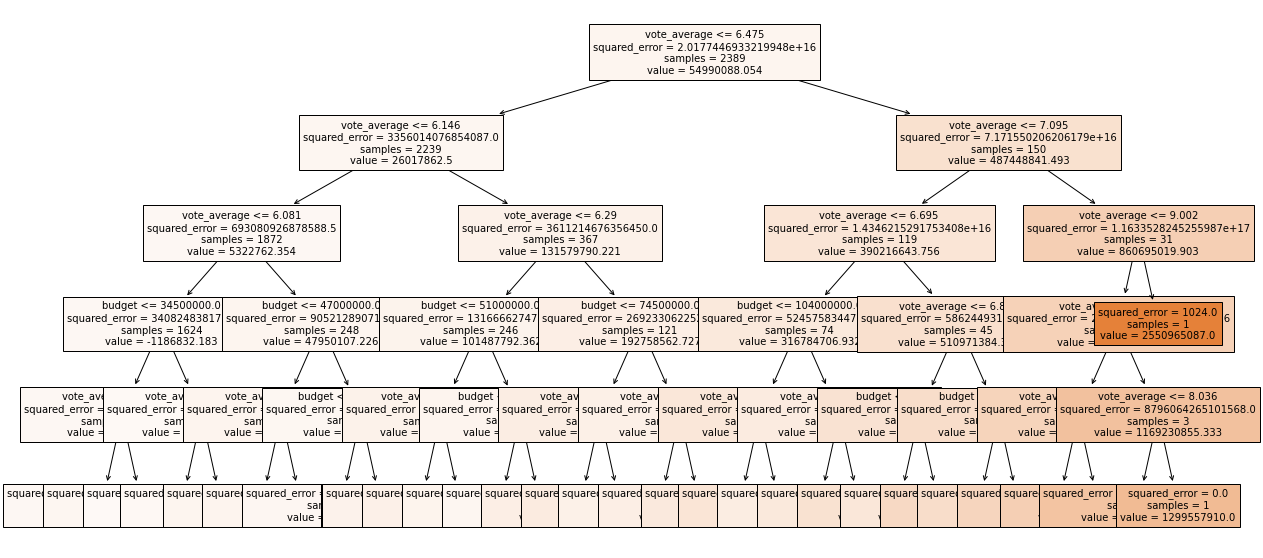

In [38]:
feature_cols = ['budget', 'vote_average', 'popularity', 'runtime']
target_col = 'profit'  
X = movies[feature_cols]
y = movies[target_col]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=3)
results = regressor.fit(X_train_imputed, y_train)

y_pred_train = regressor.predict(X_train_imputed)
y_pred_test = regressor.predict(X_test_imputed)
print("Train RMSE:", mean_squared_error(y_train, y_pred_train, squared=False))
print("Test RMSE:", mean_squared_error(y_test, y_pred_test, squared=False))

plt.figure(figsize=(20, 10))
plot_tree(regressor, filled=True, feature_names=X.columns, fontsize=10)
plt.show()

# Association rule mining

In [10]:
# Association Rule Mining
## Select relevant columns and remove missing values
selected_cols = ['director', 'cast1', 'cast2', 'cast3']
assoc_df = movies[selected_cols].dropna().copy()

## Convert the dataframe to transactional format and apply Apriori algorithm
transactions = []
for _, row in assoc_df.iterrows():
    transaction = []
    for col in selected_cols:
        transaction.append(row[col])
    transactions.append(transaction)

te = TransactionEncoder()
te_ary = te.fit_transform(transactions)
one_hot_df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(one_hot_df, min_support=0.001, use_colnames=True)
association_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

## Display the association rules
print(association_rules)

                           antecedents                         consequents  \
0                         (Adam McKay)                      (Will Ferrell)   
1                       (Dennis Dugan)                      (Adam Sandler)   
2                   (Robert Rodriguez)                  (Antonio Banderas)   
3                  (Nicole Holofcener)                  (Catherine Keener)   
4                   (Daniel Radcliffe)                       (Emma Watson)   
5                        (Emma Watson)                  (Daniel Radcliffe)   
6                   (Daniel Radcliffe)                      (Rupert Grint)   
7                       (Rupert Grint)                  (Daniel Radcliffe)   
8                    (DeForest Kelley)                     (Leonard Nimoy)   
9                      (Leonard Nimoy)                   (DeForest Kelley)   
10                   (William Shatner)                   (DeForest Kelley)   
11                   (DeForest Kelley)                   (Willia